# Daijisen Dictionary EDA - Information Retrieval Analysis

## Mục tiêu
Phân tích toàn diện dữ liệu từ điển Daijisen (大辞泉) để:
1. **Hiểu rõ bản chất dữ liệu**: Cấu trúc, phân bố, đặc điểm
2. **Tìm ra các issues**: Data quality, missing values, duplicates, inconsistencies
3. **Đánh giá khả năng IR**: Text characteristics, vocabulary distribution, indexing potential
4. **Xây dựng hệ thống IR hiệu quả**: Recommendations và insights

## Dataset Info
- **Source**: Daijisen 第二版 [2025-04-29]
- **Total entries**: ~764,381 records
- **Format**: JSONL (JSON Lines)
- **Language**: Japanese (JA-JA dictionary)

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from pathlib import Path
from daijisen import PROJECT_ROOT
import re
import warnings
warnings.filterwarnings('ignore')

# Japanese text support
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Meiryo']
plt.rcParams['axes.unicode_minus'] = False

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
PROCESSED_DATASET = PROJECT_ROOT / "Processed Data"
# Simple progress tracker (no dependencies)
def progress_tracker(iterable, desc="Processing", total=None):
    """Simple progress tracker without external dependencies"""
    if total is None:
        try:
            total = len(iterable)
        except:
            total = None
    
    if total:
        print(f"{desc}: 0/{total:,}", end='\r')
        for i, item in enumerate(iterable, 1):
            if i % max(1, total // 100) == 0 or i == total:  # Update every 1%
                print(f"{desc}: {i:,}/{total:,} ({i/total*100:.1f}%)", end='\r')
            yield item
        print(f"{desc}: {total:,}/{total:,} (100.0%) - Complete!")
    else:
        for i, item in enumerate(iterable, 1):
            if i % 10000 == 0:
                print(f"{desc}: {i:,} items processed...", end='\r')
            yield item
        print(f"{desc}: {i:,} items - Complete!")

## 1. Data Loading & Basic Statistics

In [2]:
# Load data
data_path = PROCESSED_DATASET / "[JA-JA]_大辞泉_第二版.jsonl"

def load_jsonl(file_path, max_rows=None):
    """Load JSONL file into list of dicts"""
    records = []
    print(f"Loading from: {file_path}")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    total = len(lines) if max_rows is None else min(max_rows, len(lines))
    
    for i, line in enumerate(progress_tracker(lines[:total], desc="Loading data", total=total)):
        records.append(json.loads(line))
    
    return records

# Load full dataset
print("="*80)
print("LOADING DATASET")
print("="*80)
records = load_jsonl(data_path)  # Load all

print(f"\n✓ Successfully loaded {len(records):,} records")

LOADING DATASET
Loading from: D:\Lafin\Personal\Ths\Web Mining\IT4868E_Web-Mining\Processed Data\[JA-JA]_大辞泉_第二版.jsonl
Loading data: 764,381/764,381 (100.0%) - Complete!

✓ Successfully loaded 764,381 records


In [3]:
# Basic statistics
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total unique words: {len(records):,}")

# Examine first record structure
sample = records[0]
print("\nSample record structure:")
print(json.dumps(sample, ensure_ascii=False, indent=2)[:500] + "...")

# Schema analysis
print("\n" + "=" * 80)
print("SCHEMA ANALYSIS")
print("=" * 80)
print("\nTop-level fields:")
for key in sample.keys():
    print(f"  - {key}: {type(sample[key]).__name__}")

print("\nEntry fields (within 'entries' list):")
if sample['entries']:
    entry = sample['entries'][0]
    for key, value in entry.items():
        print(f"  - {key}: {type(value).__name__}")

DATASET OVERVIEW
Total unique words: 764,381

Sample record structure:
{
  "word": "#8000番",
  "entries": [
    {
      "headword": "#8000番",
      "reading": "しゃーぷはっせんばん",
      "variation": "",
      "part_of_speech": "",
      "priority": 0,
      "index": 74086,
      "note": "",
      "term_bank": "term_bank_8.json",
      "definition": "シャープ‐はっせんばん【＃八〇〇〇番】\n⇒小児救急医療電話相談"
    }
  ],
  "formatted": "■ #8000番 (しゃーぷはっせんばん)\n   [Part of Speech: —]\n   ----------\n   シャープ‐はっせんばん【＃八〇〇〇番】\n   ⇒小児救急医療電話相談"
}...

SCHEMA ANALYSIS

Top-level fields:
  - word: str
  - entries: list
  - formatted: str

Entry fields (within 'entries' list):
  - headword: str
  - reading: str
  - variation: str
  - part_of_speech: str
  - priority: int
  - index: int
  - note: str
  - term_bank: str
  - definition: str


## 2. Data Quality Analysis

### 2.1 Missing Values & Empty Fields

In [4]:
# Analyze missing/empty values
def analyze_missing_values(records):
    """Analyze missing and empty values in entries"""
    stats = defaultdict(lambda: {'total': 0, 'empty': 0, 'missing': 0, 'placeholder': 0})
    
    for record in progress_tracker(records, desc="Analyzing missing values"):
        for entry in record.get('entries', []):
            for key, value in entry.items():
                stats[key]['total'] += 1
                
                # Check missing
                if value is None:
                    stats[key]['missing'] += 1
                
                # Check empty string
                elif isinstance(value, str) and value.strip() == '':
                    stats[key]['empty'] += 1
                
                # Check placeholder (? or —)
                elif isinstance(value, str) and value.strip() in ['?', '—', '―']:
                    stats[key]['placeholder'] += 1
    
    return stats

missing_stats = analyze_missing_values(records)

# Display results
print("\n" + "=" * 100)
print("MISSING VALUES ANALYSIS")
print("=" * 100)
print(f"{'Field':<20} {'Total':>12} {'Empty':>12} {'Missing':>12} {'Placeholder':>12} {'Empty %':>12}")
print("-" * 100)

for field, stat in sorted(missing_stats.items()):
    total = stat['total']
    empty = stat['empty']
    missing = stat['missing']
    placeholder = stat['placeholder']
    empty_pct = (empty + missing + placeholder) / total * 100 if total > 0 else 0
    
    print(f"{field:<20} {total:>12,} {empty:>12,} {missing:>12,} {placeholder:>12,} {empty_pct:>11.2f}%")

Analyzing missing values: 764,381/764,381 (100.0%) - Complete!

MISSING VALUES ANALYSIS
Field                       Total        Empty      Missing  Placeholder      Empty %
----------------------------------------------------------------------------------------------------
definition                959,882            0            0            0        0.00%
headword                  959,882            0            0            0        0.00%
index                     959,882            0            0            0        0.00%
note                      959,882      959,882            0            0      100.00%
part_of_speech            959,882      905,388            0            0       94.32%
priority                  959,882            0            0            0        0.00%
reading                   959,882      305,814            0            0       31.86%
term_bank                 959,882            0            0            0        0.00%
variation                 959,882    

### 2.2 Duplicate Detection

In [5]:
# Duplicate analysis
print("=" * 80)
print("DUPLICATE ANALYSIS")
print("=" * 80)

# Count words
word_counts = Counter(r['word'] for r in records)
duplicates = {word: count for word, count in word_counts.items() if count > 1}

print(f"\nTotal unique words: {len(word_counts):,}")
print(f"Duplicate words: {len(duplicates):,}")
print(f"Duplicate rate: {len(duplicates) / len(word_counts) * 100:.2f}%")

# Show top duplicates
print("\nTop 20 most duplicated words:")
print(f"{'Word':<30} {'Count':>10}")
print("-" * 42)
for word, count in sorted(duplicates.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{word:<30} {count:>10}")

# Entries per word distribution
entries_per_word = [len(r['entries']) for r in records]
print(f"\nEntries per word statistics:")
print(f"  Mean: {np.mean(entries_per_word):.2f}")
print(f"  Median: {np.median(entries_per_word):.0f}")
print(f"  Max: {np.max(entries_per_word)}")
print(f"  Min: {np.min(entries_per_word)}")

DUPLICATE ANALYSIS

Total unique words: 764,381
Duplicate words: 0
Duplicate rate: 0.00%

Top 20 most duplicated words:
Word                                Count
------------------------------------------

Entries per word statistics:
  Mean: 1.26
  Median: 1
  Max: 161
  Min: 1


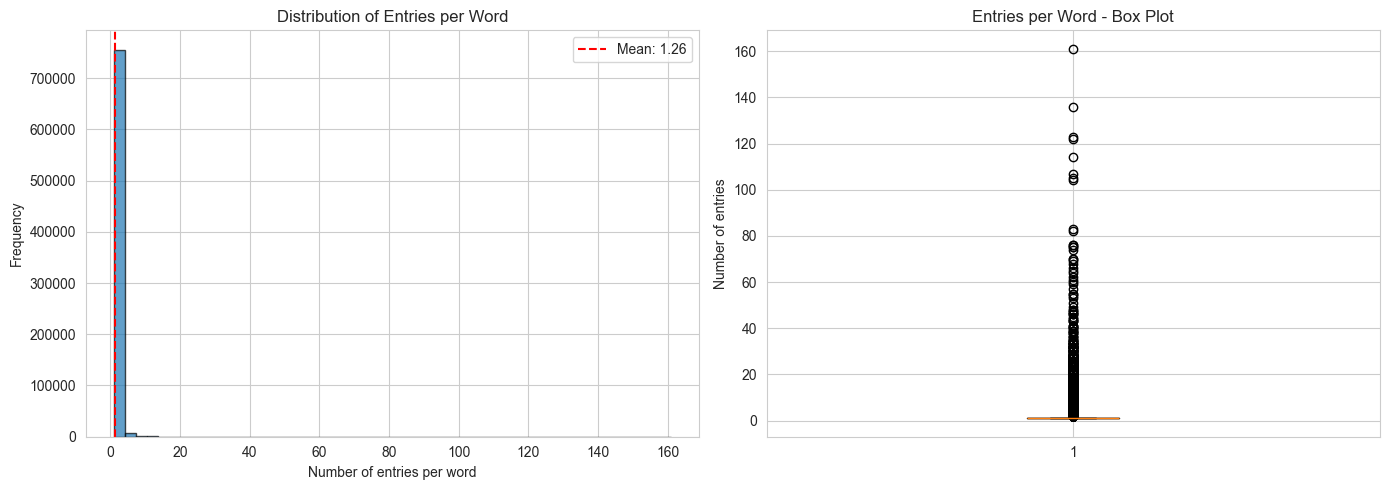

In [6]:
# Visualize entries per word distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(entries_per_word, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of entries per word')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Entries per Word')
axes[0].axvline(np.mean(entries_per_word), color='red', linestyle='--', label=f'Mean: {np.mean(entries_per_word):.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(entries_per_word, vert=True)
axes[1].set_ylabel('Number of entries')
axes[1].set_title('Entries per Word - Box Plot')

plt.tight_layout()
plt.show()

## 3. Text Characteristics for IR

### 3.1 Word & Definition Length Analysis

In [7]:
# Text length analysis
def analyze_text_lengths(records):
    """Analyze lengths of various text fields"""
    stats = {
        'word_length': [],
        'reading_length': [],
        'definition_length': [],
        'formatted_length': [],
    }
    
    for record in progress_tracker(records, desc="Analyzing text lengths"):
        # Word length
        stats['word_length'].append(len(record.get('word', '')))
        
        # Formatted length
        stats['formatted_length'].append(len(record.get('formatted', '')))
        
        # Entry-level stats
        for entry in record.get('entries', []):
            stats['reading_length'].append(len(entry.get('reading', '')))
            stats['definition_length'].append(len(entry.get('definition', '')))
    
    return stats

length_stats = analyze_text_lengths(records)

# Display statistics
print("\n" + "=" * 100)
print("TEXT LENGTH STATISTICS")
print("=" * 100)
print(f"{'Field':<20} {'Mean':>12} {'Median':>12} {'Min':>12} {'Max':>12} {'Std':>12}")
print("-" * 100)

for field, values in length_stats.items():
    values = [v for v in values if v > 0]  # Remove zeros
    if values:
        print(f"{field:<20} {np.mean(values):>12.2f} {np.median(values):>12.0f} "
              f"{np.min(values):>12} {np.max(values):>12} {np.std(values):>12.2f}")

Analyzing text lengths: 764,381/764,381 (100.0%) - Complete!

TEXT LENGTH STATISTICS
Field                        Mean       Median          Min          Max          Std
----------------------------------------------------------------------------------------------------
word_length                  6.31            5            1          131         4.63
reading_length               6.06            5            1           49         3.26
definition_length           99.72           78            6         5309        87.70
formatted_length           200.90          149           61        30160       241.74


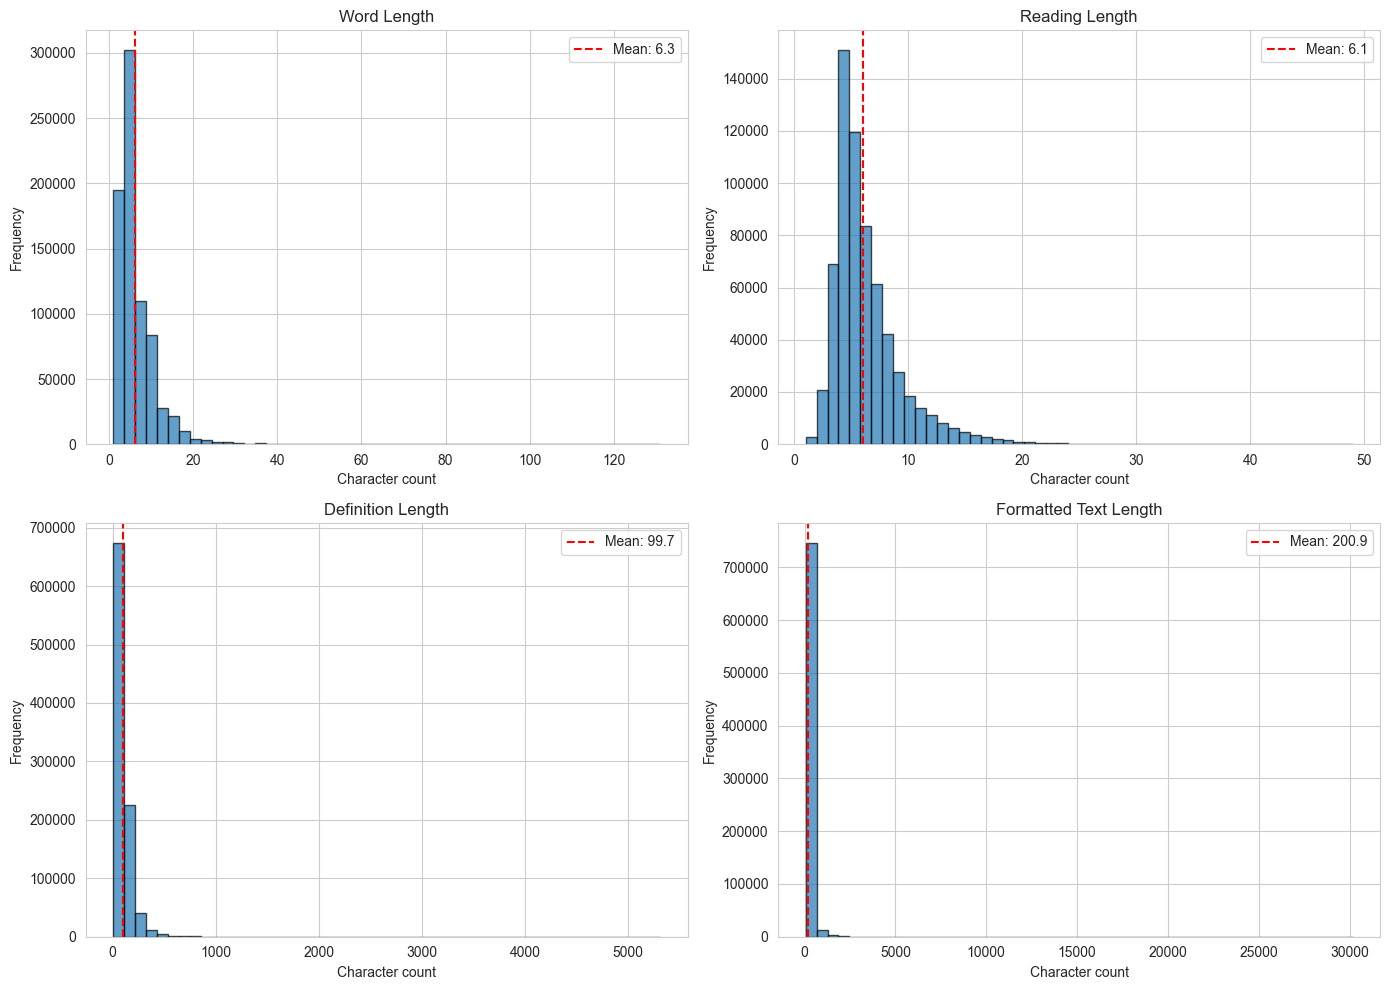

In [8]:
# Visualize length distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

fields = ['word_length', 'reading_length', 'definition_length', 'formatted_length']
titles = ['Word Length', 'Reading Length', 'Definition Length', 'Formatted Text Length']

for ax, field, title in zip(axes.flat, fields, titles):
    data = [v for v in length_stats[field] if v > 0]
    ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Character count')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.axvline(np.mean(data), color='red', linestyle='--', label=f'Mean: {np.mean(data):.1f}')
    ax.legend()

plt.tight_layout()
plt.show()

### 3.2 Part of Speech Distribution

In [9]:
# Part of speech analysis
pos_counter = Counter()

for record in progress_tracker(records, desc="Analyzing POS"):
    for entry in record.get('entries', []):
        pos = entry.get('part_of_speech', '').strip()
        if pos:
            pos_counter[pos] += 1
        else:
            pos_counter['(empty)'] += 1

print("\n" + "=" * 80)
print("PART OF SPEECH DISTRIBUTION")
print("=" * 80)
print(f"\nTotal unique POS tags: {len(pos_counter)}")
print(f"\nTop 30 most common POS tags:")
print(f"{'POS Tag':<30} {'Count':>12} {'Percentage':>12}")
print("-" * 56)

total = sum(pos_counter.values())
for pos, count in pos_counter.most_common(30):
    pct = count / total * 100
    print(f"{pos:<30} {count:>12,} {pct:>11.2f}%")

Analyzing POS: 764,381/764,381 (100.0%) - Complete!

PART OF SPEECH DISTRIBUTION

Total unique POS tags: 9

Top 30 most common POS tags:
POS Tag                               Count   Percentage
--------------------------------------------------------
(empty)                             905,388       94.32%
v5                                   35,007        3.65%
v1                                   12,695        1.32%
adj-i                                 5,114        0.53%
vs                                    1,238        0.13%
vz                                      260        0.03%
vk                                      120        0.01%
v5 vs                                    44        0.00%
v5 v1                                    16        0.00%


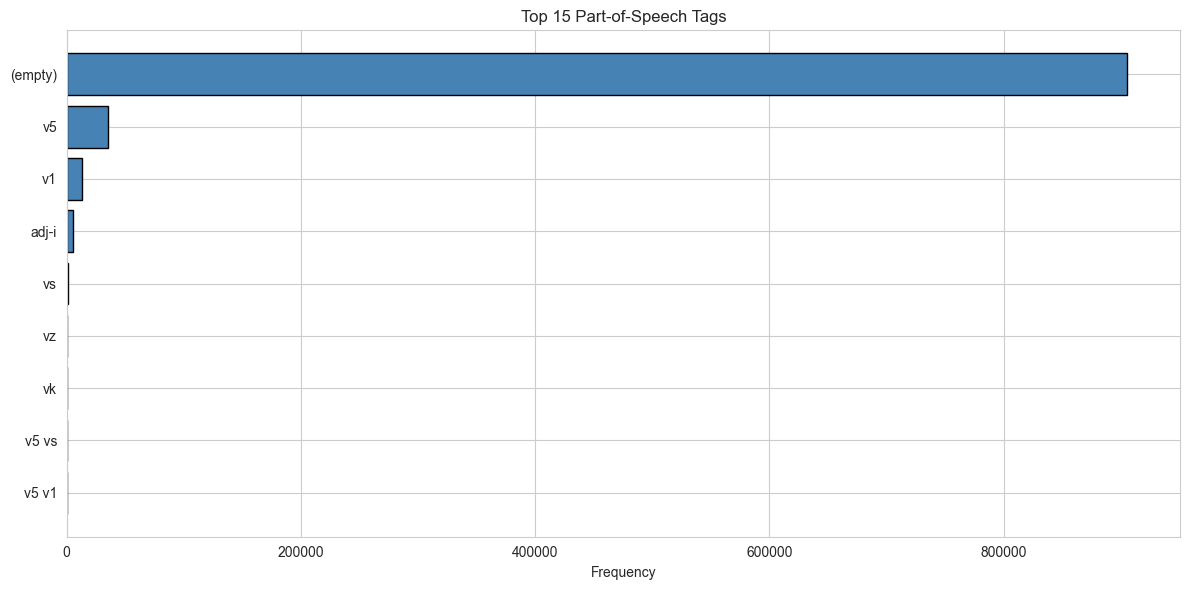

In [10]:
# Visualize top POS tags
top_pos = pos_counter.most_common(15)
labels, values = zip(*top_pos)

plt.figure(figsize=(12, 6))
plt.barh(range(len(labels)), values, color='steelblue', edgecolor='black')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Frequency')
plt.title('Top 15 Part-of-Speech Tags')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 3.3 Character Type Analysis (Hiragana, Katakana, Kanji, etc.)

In [11]:
# Character type analysis
def classify_japanese_char(char):
    """Classify a character as hiragana, katakana, kanji, or other"""
    code = ord(char)
    
    # Hiragana: U+3040–U+309F
    if 0x3040 <= code <= 0x309F:
        return 'hiragana'
    
    # Katakana: U+30A0–U+30FF
    if 0x30A0 <= code <= 0x30FF:
        return 'katakana'
    
    # Kanji: CJK Unified Ideographs U+4E00–U+9FFF
    if 0x4E00 <= code <= 0x9FFF:
        return 'kanji'
    
    # Kanji extensions
    if 0x3400 <= code <= 0x4DBF or 0x20000 <= code <= 0x2A6DF:
        return 'kanji'
    
    # ASCII/Latin
    if code < 0x80:
        return 'ascii'
    
    return 'other'

def analyze_word_composition(word):
    """Analyze character composition of a word"""
    composition = Counter(classify_japanese_char(c) for c in word)
    return composition

# Analyze word compositions
char_type_stats = Counter()
word_type_patterns = Counter()

for record in progress_tracker(records, desc="Analyzing character types"):
    word = record.get('word', '')
    composition = analyze_word_composition(word)
    
    # Aggregate character types
    char_type_stats.update(composition)
    
    # Determine dominant pattern
    if composition:
        dominant = composition.most_common(1)[0][0]
        if len(composition) == 1:
            pattern = f"pure_{dominant}"
        else:
            pattern = f"mixed_{dominant}"
        word_type_patterns[pattern] += 1

print("\n" + "=" * 80)
print("CHARACTER TYPE DISTRIBUTION")
print("=" * 80)
print("\nCharacter type counts:")
print(f"{'Type':<20} {'Count':>15}")
print("-" * 37)
for char_type, count in char_type_stats.most_common():
    print(f"{char_type:<20} {count:>15,}")

print("\n\nWord composition patterns:")
print(f"{'Pattern':<20} {'Count':>15}")
print("-" * 37)
for pattern, count in word_type_patterns.most_common():
    print(f"{pattern:<20} {count:>15,}")

Analyzing character types: 764,381/764,381 (100.0%) - Complete!

CHARACTER TYPE DISTRIBUTION

Character type counts:
Type                           Count
-------------------------------------
hiragana                   1,864,281
kanji                      1,056,949
ascii                        953,084
katakana                     934,402
other                         12,581


Word composition patterns:
Pattern                        Count
-------------------------------------
pure_hiragana                201,605
pure_kanji                   189,542
pure_katakana                101,295
mixed_hiragana                89,524
mixed_kanji                   84,628
pure_ascii                    73,935
mixed_katakana                20,350
mixed_ascii                    2,268
pure_other                       760
mixed_other                      474


### 3.4 Vocabulary Diversity & Rare Words

In [12]:
# Word frequency in definitions
from collections import defaultdict

# Simple tokenization without MeCab
def tokenize_japanese(text):
    """Simple Japanese tokenizer without external dependencies"""
    # Split on whitespace and common punctuation
    tokens = re.findall(r'[\w]+', text)
    return tokens

# Analyze vocabulary in definitions
vocab_counter = Counter()
sample_size = min(10000, len(records))  # Sample để tránh quá lâu

print("=" * 80)
print(f"VOCABULARY ANALYSIS (sampling {sample_size:,} random definitions)")
print("=" * 80)

import random
random.seed(42)  # For reproducibility
sample_records = random.sample(records, sample_size)

for record in progress_tracker(sample_records, desc="Tokenizing definitions"):
    for entry in record.get('entries', []):
        definition = entry.get('definition', '')
        tokens = tokenize_japanese(definition)
        vocab_counter.update(tokens)

print(f"\n✓ Total unique tokens in definitions: {len(vocab_counter):,}")
print(f"✓ Total tokens: {sum(vocab_counter.values()):,}")

print("\n\nTop 50 most frequent tokens:")
print(f"{'Token':<20} {'Frequency':>12}")
print("-" * 34)
for token, freq in vocab_counter.most_common(50):
    print(f"{token:<20} {freq:>12,}")

VOCABULARY ANALYSIS (sampling 10,000 random definitions)
Tokenizing definitions: 10,000/10,000 (100.0%) - Complete!

✓ Total unique tokens in definitions: 98,736
✓ Total tokens: 178,270


Top 50 most frequent tokens:
Token                   Frequency
----------------------------------
アクセント                       2,800
類語                          1,416
また                          1,089
名                             667
る                             464
し                             412
補説                            379
に同じ                           361
二                             357
2                             349
一                             346
四                             342
の                             314
す                             304
き                             300
り                             277
い                             268
く                             261
する                            248
1                             242
とも                            241


## 4. Data Quality Issues Summary

In [13]:
print("=" * 100)
print("DATA QUALITY ISSUES SUMMARY")
print("=" * 100)

issues = []

# Issue 1: Missing readings
empty_reading_count = missing_stats['reading']['empty'] + missing_stats['reading']['placeholder']
empty_reading_pct = empty_reading_count / missing_stats['reading']['total'] * 100
if empty_reading_pct > 10:
    issues.append({
        'severity': 'HIGH',
        'category': 'Missing Data',
        'description': f"{empty_reading_pct:.1f}% of entries have missing/placeholder readings",
        'impact': 'Affects phonetic search and reading-based retrieval',
        'recommendation': 'Consider using headword as fallback for search when reading is missing'
    })

# Issue 2: Missing POS
empty_pos_count = missing_stats['part_of_speech']['empty']
empty_pos_pct = empty_pos_count / missing_stats['part_of_speech']['total'] * 100
if empty_pos_pct > 50:
    issues.append({
        'severity': 'MEDIUM',
        'category': 'Missing Data',
        'description': f"{empty_pos_pct:.1f}% of entries have missing POS tags",
        'impact': 'Cannot filter by grammatical category',
        'recommendation': 'POS filtering should be optional in IR system'
    })

# Issue 3: Duplicates
if len(duplicates) > 0:
    issues.append({
        'severity': 'INFO',
        'category': 'Data Structure',
        'description': f"{len(duplicates):,} words have multiple entries (homonyms/polysemy)",
        'impact': 'Search results may return multiple definitions per word',
        'recommendation': 'IR system should rank/cluster multiple definitions appropriately'
    })

# Issue 4: Variable definition length
def_lengths = [v for v in length_stats['definition_length'] if v > 0]
if np.std(def_lengths) > np.mean(def_lengths):
    issues.append({
        'severity': 'LOW',
        'category': 'Text Characteristics',
        'description': f"High variance in definition length (std={np.std(def_lengths):.0f}, mean={np.mean(def_lengths):.0f})",
        'impact': 'May affect snippet generation and display',
        'recommendation': 'Implement intelligent truncation for long definitions in search results'
    })

# Display issues
for i, issue in enumerate(issues, 1):
    print(f"\n{i}. [{issue['severity']}] {issue['category']}")
    print(f"   Description: {issue['description']}")
    print(f"   Impact: {issue['impact']}")
    print(f"   Recommendation: {issue['recommendation']}")

print(f"\n\nTotal issues identified: {len(issues)}")

DATA QUALITY ISSUES SUMMARY

1. [HIGH] Missing Data
   Description: 31.9% of entries have missing/placeholder readings
   Impact: Affects phonetic search and reading-based retrieval
   Recommendation: Consider using headword as fallback for search when reading is missing

2. [MEDIUM] Missing Data
   Description: 94.3% of entries have missing POS tags
   Impact: Cannot filter by grammatical category
   Recommendation: POS filtering should be optional in IR system


Total issues identified: 2


## 5. Cross-Reference Network Analysis

Analyze relationships between dictionary entries through cross-references (⇒, →, etc.)

In [21]:
# Extract cross-references
def extract_references(definition):
    """Extract cross-reference patterns from definition"""
    refs = []
    
    # Pattern 1: ⇒word
    pattern1 = re.findall(r'⇒([^\s\n、。]+)', definition)
    refs.extend(pattern1)
    
    # Pattern 2: →word
    pattern2 = re.findall(r'→([^\s\n、。]+)', definition)
    refs.extend(pattern2)
    
    return refs

# Build reference graph
reference_graph = defaultdict(set)
total_references = 0

for record in progress_tracker(records, desc="Extracting references"):
    word = record['word']
    
    for entry in record.get('entries', []):
        definition = entry.get('definition', '')
        refs = extract_references(definition)
        
        for ref in refs:
            reference_graph[word].add(ref)
            total_references += 1

print(f"\n\n{'='*80}")
print("CROSS-REFERENCE NETWORK STATISTICS")
print("="*80)
print(f"Total nodes (words with references): {len(reference_graph):,}")
print(f"Total edges (reference links): {total_references:,}")
print(f"Average out-degree: {total_references / len(reference_graph):.2f}")

# Find top referenced words
in_degree = Counter()
for refs in reference_graph.values():
    in_degree.update(refs)

print("\nTop 20 most referenced words (hub terms):")
print(f"{'Word':<30} {'In-degree':>12}")
print("-"*44)
for word, count in in_degree.most_common(20):
    print(f"{word:<30} {count:>12}")

Extracting references: 764,381/764,381 (100.0%) - Complete!


CROSS-REFERENCE NETWORK STATISTICS
Total nodes (words with references): 123,497
Total edges (reference links): 149,282
Average out-degree: 1.21

Top 20 most referenced words (hub terms):
Word                              In-degree
--------------------------------------------
アメリカ合衆国補説                               201
原子力発電所補説                                128
KVMスイッチ                                  81
マイクロソフトサーフェス                             72
ウインドウズ                                   71
S                                        63
拠点空港                                     57
H                                        53
共通鍵暗号                                    52
ツーインワンPC                                 50
括弧                                       49
シー‐ユー‐アイ（CUI）                            46
フィルタリングサービス                              46
トップレベルドメイン                               46
B                                        42
デジ

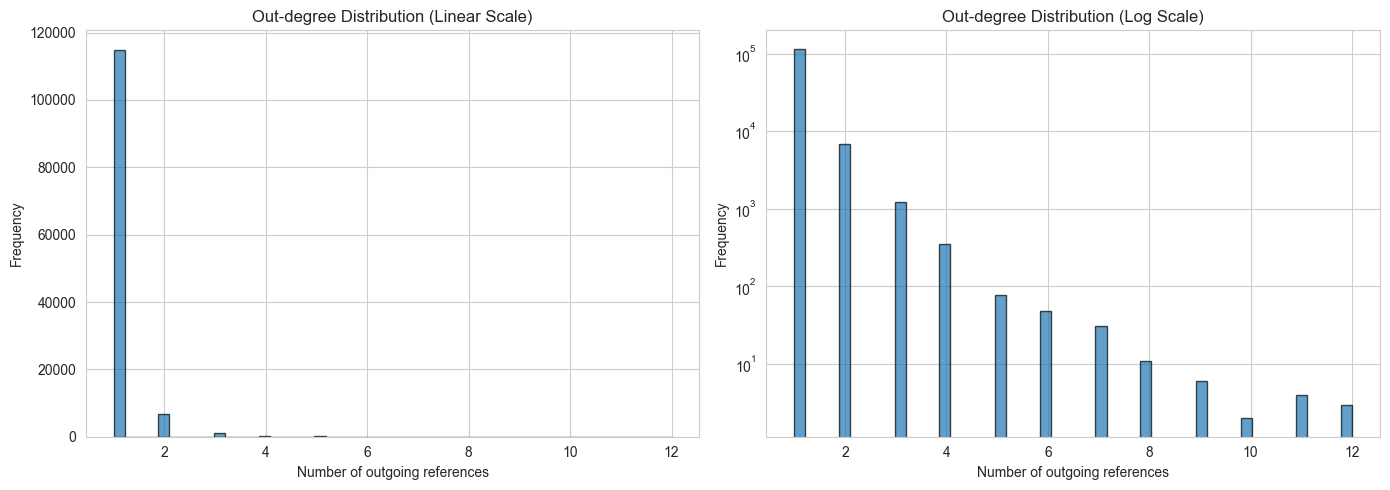


Out-degree statistics:
  Mean: 1.09
  Median: 1
  Max: 12
  Std: 0.39


In [22]:
# Visualize out-degree distribution
out_degrees = [len(refs) for refs in reference_graph.values()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(out_degrees, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of outgoing references')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Out-degree Distribution (Linear Scale)')

# Log scale
axes[1].hist(out_degrees, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of outgoing references')
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')
axes[1].set_title('Out-degree Distribution (Log Scale)')

plt.tight_layout()
plt.show()

print(f"\nOut-degree statistics:")
print(f"  Mean: {np.mean(out_degrees):.2f}")
print(f"  Median: {np.median(out_degrees):.0f}")
print(f"  Max: {np.max(out_degrees)}")
print(f"  Std: {np.std(out_degrees):.2f}")

Mạng lưới từ giống hình dạng "Cây" hoặc "Sao" cục bộ:

* Hàng trăm ngàn từ Leaf nodes chỉ trỏ về 1 nơi.

* Một số ít từ trung tâm nhận các liên kết đó.

## 6. Missing Reading Pattern Analysis

Deep dive into why readings are missing and what patterns exist

In [17]:
# Classify character types
def classify_char_type(char):
    code = ord(char)
    if 0x3040 <= code <= 0x309F:
        return 'hiragana'
    if 0x30A0 <= code <= 0x30FF:
        return 'katakana'
    if 0x4E00 <= code <= 0x9FFF:
        return 'kanji'
    if code < 0x80:
        return 'ascii'
    return 'other'

def classify_word_type(word):
    if not word:
        return 'empty'
    
    char_types = [classify_char_type(c) for c in word]
    type_counts = Counter(char_types)
    
    # Pure type if >90% is one type
    total = len(char_types)
    for char_type, count in type_counts.items():
        if count / total >= 0.9:
            return f"pure_{char_type}"
    
    # Mixed otherwise
    dominant = type_counts.most_common(1)[0][0]
    return f"mixed_{dominant}"

# Analyze missing readings by word type
reading_stats = defaultdict(lambda: {'total': 0, 'missing': 0})

for record in progress_tracker(records, desc="Analyzing missing readings"):
    word = record['word']
    word_type = classify_word_type(word)
    
    for entry in record.get('entries', []):
        reading = entry.get('reading', '').strip()
        
        reading_stats[word_type]['total'] += 1
        
        if not reading or reading == '?':
            reading_stats[word_type]['missing'] += 1

# Display results
print("\n\n" + "="*80)
print("MISSING READING ANALYSIS BY WORD TYPE")
print("="*80)
print(f"{'Word Type':<25} {'Total':>12} {'Missing':>12} {'Missing %':>12}")
print("-"*80)

for word_type in sorted(reading_stats.keys()):
    stats = reading_stats[word_type]
    total = stats['total']
    missing = stats['missing']
    pct = missing / total * 100 if total > 0 else 0
    
    print(f"{word_type:<25} {total:>12,} {missing:>12,} {pct:>11.2f}%")

Analyzing missing readings: 764,381/764,381 (100.0%) - Complete!


MISSING READING ANALYSIS BY WORD TYPE
Word Type                        Total      Missing    Missing %
--------------------------------------------------------------------------------
mixed_ascii                      2,259          925       40.95%
mixed_hiragana                  89,177       15,884       17.81%
mixed_kanji                     88,015       18,714       21.26%
mixed_katakana                  20,366       19,547       95.98%
mixed_other                        175           98       56.00%
pure_ascii                      83,010       83,005       99.99%
pure_hiragana                  348,803       31,094        8.91%
pure_kanji                     212,311       22,836       10.76%
pure_katakana                  114,453      112,424       98.23%
pure_other                       1,313        1,287       98.02%


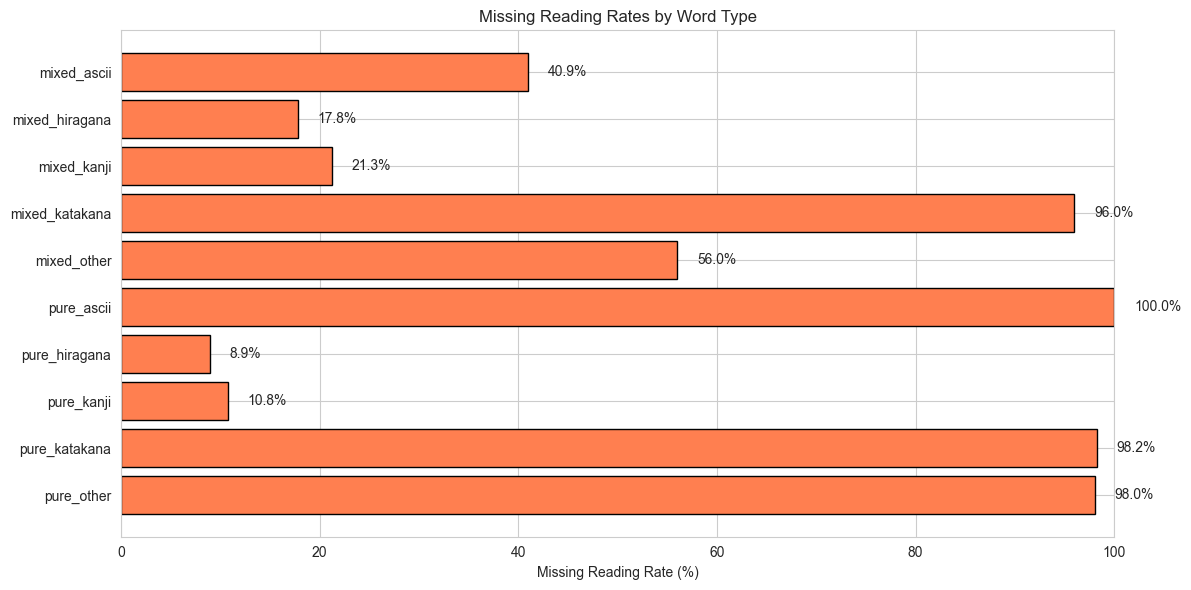

In [18]:
# Visualize missing reading rates
word_types = []
missing_rates = []

for word_type, stats in sorted(reading_stats.items()):
    if stats['total'] > 100:  # Only show significant categories
        word_types.append(word_type)
        missing_rates.append(stats['missing'] / stats['total'] * 100)

plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(word_types)), missing_rates, color='coral', edgecolor='black')
plt.yticks(range(len(word_types)), word_types)
plt.xlabel('Missing Reading Rate (%)')
plt.title('Missing Reading Rates by Word Type')
plt.xlim(0, 100)
plt.gca().invert_yaxis()

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, missing_rates)):
    plt.text(rate + 2, i, f"{rate:.1f}%", va='center')

plt.tight_layout()
plt.show()

1. Nhóm "Thiếu gần như toàn bộ" (Màu cam đậm bên phải)
Đây là nhóm có tỷ lệ thiếu reading (cách đọc/phiên âm) từ 96% đến 100%.

* pure_ascii (100%): Các từ thuần ký tự Latin (tiếng Anh, viết tắt).

Lý do: Các từ như "DNA", "Windows" không cần trường phiên âm kiểu Nhật (Furigana) vì chúng được đọc theo mặt chữ hoặc quy tắc tiếng Anh.

* pure_katakana (98.2%) & mixed_katakana (96.0%): Các từ thuần Katakana.

Lý do: Katakana bản thân nó đã là chữ biểu âm. Ví dụ: từ コンピューター (Máy tính) thì cách đọc chính là コンピューター. Việc điền thêm trường reading là dư thừa.

* pure_other (98.0%): Có thể là các ký hiệu toán học, số đếm, hoặc dấu câu. Chúng cũng không cần phiên âm.

=> Kết luận: Việc thiếu dữ liệu ở nhóm này là Tính năng, không phải Lỗi

2. Nhóm "Thiếu ít" 
Đây là nhóm mà việc thiếu reading là vấn đề thực sự cần quan tâm, vì đây thường là các từ chứa Kanji cần có phiên âm để biết cách đọc.

* pure_kanji (Chỉ thiếu 10.8%):

Với các từ thuần Hán tự (ví dụ: 日本), hệ thống đã có phiên âm cho khoảng 90% số lượng từ. Chỉ có ~11% là thực sự bị khuyết.

* mixed_kanji (Thiếu 21.3%):

Đây là các từ kết hợp Kanji và Kana (ví dụ: 食べ物). Khoảng 1/5 số từ này đang thiếu cách đọc.

* pure_hiragana (Thiếu 8.9%):

Thường Hiragana không cần phiên âm, nhưng nếu dữ liệu gốc có điền 91% thì 9% còn lại có thể là do thiếu sót nhất quán.

## 6. Polysemy Analysis

Analyze words with multiple definitions

In [23]:
# Count entries per word
polysemy_counts = [(r['word'], len(r['entries'])) for r in records]
polysemy_df = pd.DataFrame(polysemy_counts, columns=['word', 'num_definitions'])

print("="*80)
print("POLYSEMY ANALYSIS")
print("="*80)
print(f"\nDefinition count statistics:")
print(polysemy_df['num_definitions'].describe())

# Top polysemous words
print("\n\nTop 30 most polysemous words:")
print(f"{'Word':<30} {'Number of Definitions':>25}")
print("-"*57)
top_polysemous = polysemy_df.nlargest(30, 'num_definitions')
for _, row in top_polysemous.iterrows():
    print(f"{row['word']:<30} {row['num_definitions']:>25}")

POLYSEMY ANALYSIS

Definition count statistics:
count    764381.000000
mean          1.255764
std           1.106779
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         161.000000
Name: num_definitions, dtype: float64


Top 30 most polysemous words:
Word                               Number of Definitions
---------------------------------------------------------
こう                                                   161
しょう                                                  136
かん                                                   123
し                                                    122
き                                                    114
スター                                                  107
新                                                    105
そう                                                   104
とう                                                    83
か                                                     82
かい           

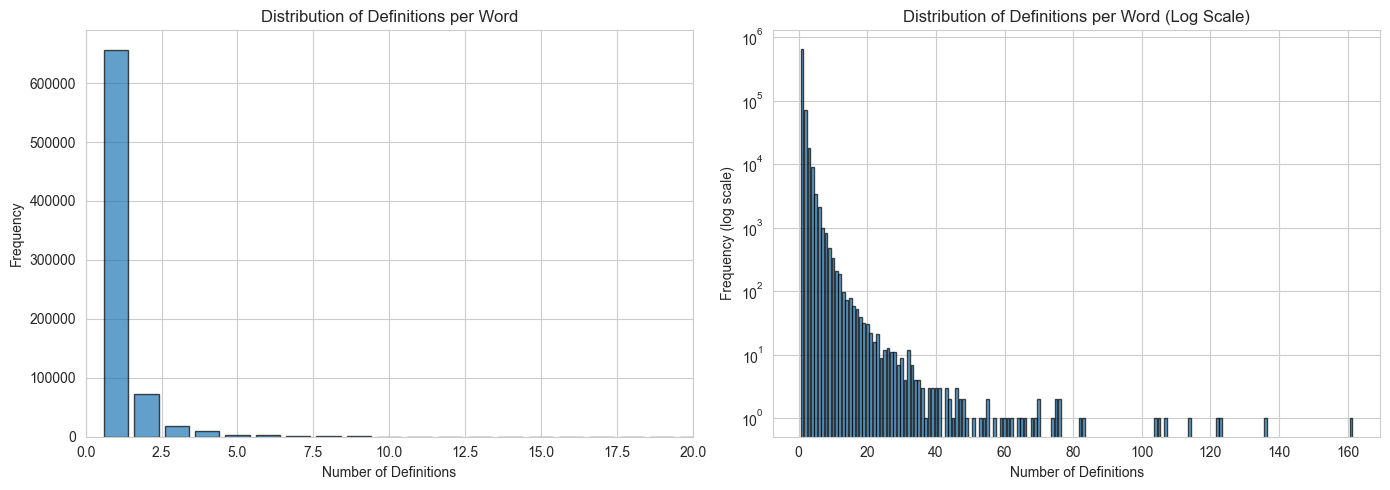

In [24]:
# Visualize polysemy distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
counts = polysemy_df['num_definitions'].value_counts().sort_index()
axes[0].bar(counts.index, counts.values, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Definitions')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Definitions per Word')
axes[0].set_xlim(0, 20)  # Limit for readability

# Log scale for tail
axes[1].bar(counts.index, counts.values, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Definitions')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_yscale('log')
axes[1].set_title('Distribution of Definitions per Word (Log Scale)')

plt.tight_layout()
plt.show()

Kết luận: 
* Đa số các từ chỉ có 1 nghĩa (chiếm tới hơn 75%), là các từ ghép dài, các từ lai,...
* Dữ liệu có hiện tượng đồng âm khác nghĩa: 1 âm nhưng có nhiều nghĩa, dẫn tới 1 từ có tới 161 nghĩa